The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Normalização de Lotes
:label:`sec_batch_norm`


Treinar redes neurais profundas é difícil.
E fazer com que eles convirjam em um período de tempo razoável pode ser complicado.
Nesta seção, descrevemos a *normalização em lote*, uma técnica popular e eficaz
que acelera consistentemente a convergência de redes profundas :cite:`Ioffe.Szegedy.2015`.
Juntamente com os blocos residuais --- cobertos posteriormente em :numref:`sec_resnet` --- normalização em lote
tornou possível para os praticantes
para treinar rotineiramente redes com mais de 100 camadas.



## Treinando Redes Profundas

Para motivar a normalização do lote, vamos revisar
alguns desafios práticos que surgem
ao treinar modelos de aprendizado de máquina e redes neurais em particular.

Em primeiro lugar, as escolhas relativas ao pré-processamento de dados costumam fazer uma enorme diferença nos resultados finais.
Lembre-se de nossa aplicação de MLPs para prever preços de casas (:numref:`sec_kaggle_house`).
Nosso primeiro passo ao trabalhar com dados reais
era padronizar nossos recursos de entrada
para cada um tem uma média de zero e variância de um.
Intuitivamente, essa padronização funciona bem com nossos otimizadores
porque coloca os parâmetros *a priori* em uma escala semelhante.

Em segundo lugar, para um MLP ou CNN típico, enquanto treinamos,
as variáveis (por exemplo, saídas de transformação afim em MLP)
em camadas intermediárias
podem assumir valores com magnitudes amplamente variáveis:
tanto ao longo das camadas da entrada até a saída, através das unidades na mesma camada,
e ao longo do tempo devido às nossas atualizações nos parâmetros do modelo.
Os inventores da normalização de lote postularam informalmente
que esse desvio na distribuição de tais variáveis poderia dificultar a convergência da rede.
Intuitivamente, podemos conjeturar que se um
camada tem valores variáveis que são 100 vezes maiores que os de outra camada,
isso pode exigir ajustes compensatórios nas taxas de aprendizagem.
   
Terceiro, redes mais profundas são complexas e facilmente capazes de overfitting.
Isso significa que a regularização se torna mais crítica.

A normalização em lote é aplicada a camadas individuais
(opcionalmente, para todos eles) e funciona da seguinte forma:
Em cada iteração de treinamento,
primeiro normalizamos as entradas (de normalização em lote)
subtraindo sua média e
dividindo por seu desvio padrão,
onde ambos são estimados com base nas estatísticas do minibatch atual.
Em seguida, aplicamos um coeficiente de escala e um deslocamento de escala.
É precisamente devido a esta *normalização* baseada em estatísticas *batch*
que *normalização de lote* deriva seu nome.

Observe que se tentamos aplicar a normalização de lote com minibatches de tamanho 1,
não seríamos capazes de aprender nada.
Isso porque depois de subtrair as médias,
cada unidade oculta teria valor 0!
Como você pode imaginar, uma vez que estamos dedicando uma seção inteira à normalização em lote,
com minibatches grandes o suficiente, a abordagem se mostra eficaz e estável.
Uma lição aqui é que, ao aplicar a normalização em lote,
a escolha do tamanho do lote pode ser
ainda mais significativo do que sem normalização em lote.

Formalmente, denotando por $\mathbf{x} \in \mathcal{B}$ uma entrada para normalização em lote ($\mathrm{BN}$)
que é de um minibatch $\mathcal{B}$,
a normalização em lote transforma $\mathbf{x}$
de acordo com a seguinte expressão:

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$
:eqlabel:`eq_batchnorm`

Em :eqref:`eq_batchnorm`, 
$\hat{\boldsymbol{\mu}}_\mathcal{B}$ é a média da amostra
e $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ é o desvio padrão da amostra do minibatch $\mathcal{B}$.
Depois de aplicar a padronização,
o minibatch resultante
tem média zero e variância unitária.
Porque a escolha da variação da unidade
(vs. algum outro número mágico) é uma escolha arbitrária,
normalmente incluímos elemento a elemento
*parâmetro de escala* $\boldsymbol{\gamma}$ e *parâmetro de deslocamento* $\boldsymbol{\beta}$
que tem a mesma forma de $\mathbf{x}$.
Observe que $\boldsymbol{\gamma}$ e$\boldsymbol{\beta}$ são
  parâmetros que precisam ser aprendidos em conjunto com os outros parâmetros do modelo.

Consequentemente, as magnitudes variáveis
para camadas intermediárias não pode divergir durante o treinamento
porque a normalização em lote centra ativamente e os redimensiona de volta
para uma dada média e tamanho (via $\hat{\boldsymbol{\mu}}_\mathcal{B}$ e ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$)
Um pedaço da intuição ou sabedoria do praticante
é que a normalização em lote parece permitir taxas de aprendizagem mais agressivas.

Formalmente, calculamos $\hat{\boldsymbol{\mu}}_\mathcal{B}$ e${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ em :eqref:`eq_batchnorm` como a seguir:

$$\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}$$

Observe que adicionamos uma pequena constante $\epsilon > 0$
para a estimativa de variância
para garantir que nunca tentemos a divisão por zero,
mesmo nos casos em que a estimativa de variância empírica pode desaparecer.
As estimativas $\hat{\boldsymbol{\mu}}_\mathcal{B}$ e ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ neutralizam o problema de escala
usando estimativas ruidosas de média e variância.
Você pode pensar que esse barulho deve ser um problema.
Acontece que isso é realmente benéfico.

Esse é um tema recorrente no aprendizado profundo.
Por razões que ainda não são bem caracterizadas teoricamente,
várias fontes de ruído na otimização
muitas vezes levam a um treinamento mais rápido e menor sobreajuste:
essa variação parece atuar como uma forma de regularização.
Em algumas pesquisas preliminares, :cite:`Teye.Azizpour.Smith.2018` e :cite:`Luo.Wang.Shao.ea.2018`
relacionam as propriedades de normalização de lote aos antecedentes e penalidades Bayesianas, respectivamente.
Em particular, isso lança alguma luz sobre o quebra-cabeça
de por que a normalização em lote funciona melhor para tamanhos moderados de minibatches na faixa de $50 \sim 100$.

Consertando um modelo treinado, você pode pensar
que preferiríamos usar todo o conjunto de dados
para estimar a média e a variância.
Depois que o treinamento for concluído, por que desejaríamos
a mesma imagem a ser classificada de forma diferente,
dependendo do lote em que reside?
Durante o treinamento, esse cálculo exato é inviável
porque as variáveis intermediárias
para todos os exemplos de dados
mudar toda vez que atualizamos nosso modelo.
No entanto, uma vez que o modelo é treinado,
podemos calcular as médias e variações
das variáveis de cada camada com base em todo o conjunto de dados.
Na verdade, esta é uma prática padrão para
modelos que empregam normalização em lote
e, portanto, as camadas de normalização em lote funcionam de maneira diferente
no *modo de treinamento* (normalizando por estatísticas de minibatch)
e no *modo de previsão* (normalizando por estatísticas do conjunto de dados).

Agora estamos prontos para dar uma olhada em como a normalização em lote funciona na prática.

## Camadas de Normalização de Lotes

Implementações de normalização em lote para camadas totalmente conectadas
e as camadas convolucionais são ligeiramente diferentes.
Discutimos ambos os casos abaixo.
Lembre-se de que uma diferença fundamental entre a normalização em lote e outras camadas
é que porque a normalização de lote opera em um minibatch completo por vez,
não podemos simplesmente ignorar a dimensão do lote
como fizemos antes ao introduzir outras camadas.

### Camadas Completamente Conectadas

Ao aplicar a normalização de lote a camadas totalmente conectadas,
o papel original insere a normalização do lote após a transformação afim
e antes da função de ativação não linear (aplicativos posteriores podem inserir a normalização em lote logo após as funções de ativação) :cite:`Ioffe.Szegedy.2015`.
Denotando a entrada para a camada totalmente conectada por $\mathbf{x}$,
a transformação afim
por $\mathbf{W}\mathbf{x} + \mathbf{b}$ (com o parâmetro de peso $\mathbf{W}$ e o parâmetro de polarização $\mathbf{b}$),
e a função de ativação por $\phi$,
podemos expressar o cálculo de uma normalização de lote habilitada,
saída de camada totalmente conectada $\mathbf{h}$ como segue:

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Lembre-se de que a média e a variância são calculadas
no *mesmo* minibatch
no qual a transformação é aplicada.

### Convolutional Layers

Da mesma forma, com camadas convolucionais,
podemos aplicar a normalização de lote após a convolução
e antes da função de ativação não linear.
Quando a convolução tem vários canais de saída,
precisamos realizar a normalização do lote
para *cada* uma das saídas desses canais,
e cada canal tem sua própria escala e parâmetros de deslocamento,
ambos são escalares.
Suponha que nossos minibatches contenham $m$ exemplos
e isso para cada canal,
a saída da convolução tem altura $p$ e largura $q$.
Para camadas convolucionais, realizamos a normalização de cada lote
nos elementos $m \cdot p \cdot q$ por canal de saída simultaneamente.
Assim, coletamos os valores de todas as localizações espaciais
ao calcular a média e a variância
e consequentemente
aplique a mesma média e variância
dentro de um determinado canal
para normalizar o valor em cada localização espacial.


### Normalização de Lotes Durante Predição

Como mencionamos anteriormente, a normalização em lote normalmente se comporta de maneira diferente
no modo de treinamento e no modo de previsão.
Primeiro, o ruído na média da amostra e a variância da amostra
decorrentes da estimativa de cada um em minibatches
não são mais desejáveis, uma vez que treinamos o modelo.
Em segundo lugar, podemos não ter o luxo
de computação de estatísticas de normalização por lote.
Por exemplo,
podemos precisar aplicar nosso modelo para fazer uma previsão de cada vez.

Normalmente, após o treinamento, usamos todo o conjunto de dados
para calcular estimativas estáveis das estatísticas variáveis
e, em seguida, corrigi-los no momento da previsão.
Consequentemente, a normalização do lote se comporta de maneira diferente durante o treinamento e no momento do teste.
Lembre-se de que o abandono também exibe essa característica.

## Implementação do Zero

Abaixo, implementamos uma camada de normalização em lote com tensores do zero.


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

Agora podemos criar uma camada `BatchNorm` adequada.
Nossa camada manterá os parâmetros adequados
para escala `gama` e deslocamento` beta`,
ambos serão atualizados no decorrer do treinamento.
Além disso, nossa camada manterá
médias móveis das médias e variâncias
para uso subsequente durante a previsão do modelo.

Deixando de lado os detalhes algorítmicos,
observe o padrão de design subjacente à nossa implementação da camada.
Normalmente, definimos a matemática em uma função separada, digamos `batch_norm`.
Em seguida, integramos essa funcionalidade em uma camada personalizada,
cujo código aborda principalmente questões de contabilidade,
como mover dados para o contexto certo do dispositivo,
alocar e inicializar quaisquer variáveis necessárias,
acompanhar as médias móveis (aqui para média e variância) e assim por diante.
Esse padrão permite uma separação clara da matemática do código clichê.
Observe também que por uma questão de conveniência
não nos preocupamos em inferir automaticamente a forma de entrada aqui,
portanto, precisamos especificar o número de recursos por toda parte.
Não se preocupe, as APIs de normalização de lote de alto nível na estrutura de aprendizado profundo cuidarão disso para nós e iremos demonstrar isso mais tarde.


In [2]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## Aplicando Normalização de Lotes em LeNet

Para ver como aplicar `BatchNorm` no contexto,
abaixo nós o aplicamos a um modelo LeNet tradicional (:numref:`sec_lenet`).
Lembre-se de que a normalização de lote é aplicada
após as camadas convolucionais ou camadas totalmente conectadas
mas antes das funções de ativação correspondentes.


In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

Como antes, treinaremos nossa rede no conjunto de dados Fashion-MNIST.
Este código é virtualmente idêntico àquele quando treinamos o LeNet pela primeira vez (:numref:`sec_lenet`).
A principal diferença é a taxa de aprendizagem consideravelmente maior.


loss 0.252, train acc 0.907, test acc 0.873
32992.0 examples/sec on cuda:0


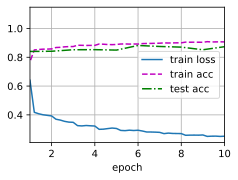

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Vamos dar uma olhada no parâmetro de escala `gamma`
e o parâmetro *shift* `beta` aprendeu
da primeira camada de normalização de lote.


In [5]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.2128, 1.1740, 2.2003, 2.2349, 2.1905, 1.4201], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-1.2550,  0.3122, -0.2924,  1.2467,  1.2471, -0.0674], device='cuda:0',
        grad_fn=<ViewBackward>))

## Implementação Concisa

Comparado com a classe `BatchNorm`,
que acabamos de definir a nós mesmos,
podemos usar a classe `BatchNorm` definida em APIs de alto nível diretamente do framework de aprendizado profundo.
O código parece virtualmente idêntico
para a aplicação nossa implementação acima.


In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

Abaixo, usamos os mesmos hiperparâmetros para treinar nosso modelo.
Observe que, como de costume, a variante de API de alto nível é executada muito mais rápido
porque seu código foi compilado para C ++ ou CUDA
enquanto nossa implementação customizada deve ser interpretada por Python.


loss 0.248, train acc 0.908, test acc 0.838
58305.7 examples/sec on cuda:0


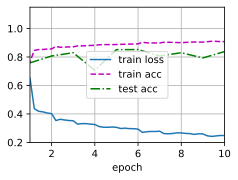

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Controvérsia

Intuitivamente, a normalização de lote é pensada
para tornar o cenário de otimização mais suave.
No entanto, devemos ter o cuidado de distinguir entre
intuições especulativas e explicações verdadeiras
para os fenômenos que observamos ao treinar modelos profundos.
Lembre-se que não sabemos nem porque é mais simples
redes neurais profundas (MLPs e CNNs convencionais)
generalize bem em primeiro lugar.
Mesmo com abandono e queda de peso,
eles permanecem tão flexíveis que sua capacidade de generalizar para dados invisíveis
não pode ser explicado por meio de garantias convencionais de generalização da teoria da aprendizagem.

No artigo original, propondo a normalização do lote,
os autores, além de apresentar uma ferramenta poderosa e útil,
ofereceram uma explicação de por que funciona:
reduzindo *deslocamento interno da covariável*.
Presumivelmente por *mudança interna de covariável* os autores
significava algo como a intuição expressa acima --- a
noção de que a distribuição dos valores das variáveis ​​muda
ao longo do treinamento.
No entanto, houve dois problemas com esta explicação:
i) Esta deriva é muito diferente de *mudança de covariável*,
tornando o nome um nome impróprio.
ii) A explicação oferece uma intuição subespecificada
mas deixa a questão de *por que exatamente essa técnica funciona*
uma questão aberta que necessita de uma explicação rigorosa.
Ao longo deste livro, pretendemos transmitir as intuições de que os praticantes
usar para orientar o desenvolvimento de redes neurais profundas.
No entanto, acreditamos que é importante
para separar essas intuições orientadoras
a partir de fato científico estabelecido.
Eventualmente, quando você dominar este material
e comece a escrever seus próprios artigos de pesquisa
você vai querer ser claro para delinear
entre afirmações técnicas e palpites.

Após o sucesso da normalização em lote,
sua explicação em termos de *mudança interna de covariável*
tem aparecido repetidamente em debates na literatura técnica
e um discurso mais amplo sobre como apresentar a pesquisa de aprendizado de máquina.
Em um discurso memorável ao aceitar o Prêmio Teste do Tempo
na conferência NeurIPS de 2017,
Ali Rahimi usou *mudança de covariável interna*
como um ponto focal em um argumento comparando
a prática moderna de aprendizado profundo a alquimia.
Posteriormente, o exemplo foi revisitado em detalhes
em um artigo opinativo delineando
tendências preocupantes em aprendizado de máquina :cite:`Lipton.Steinhardt.2018`.
Outros autores
propuseram explicações alternativas para o sucesso da normalização em lote,
alguns alegando que o sucesso da normalização em lote vem apesar de exibir comportamento
 ,de certa forma, oposto ao afirmado no artigo original :cite:`Santurkar.Tsipras.Ilyas.ea.2018`.

Notamos que a *mudança interna da covariável*
não é mais digna de crítica do que qualquer uma dos
milhares de afirmações igualmente vagas
feitas todos os anos na literatura técnica de aprendizado de máquina.
Provavelmente, sua ressonância como ponto focal desses debates
deve-se ao seu amplo reconhecimento pelo público-alvo.
A normalização em lote provou ser um método indispensável,
aplicado em quase todos os classificadores de imagem implantados,
ganhando o papel que introduziu a técnica
dezenas de milhares de citações.


## Sumário

* Durante o treinamento do modelo, a normalização em lote ajusta continuamente a saída intermediária da rede neural, utilizando a média e o desvio padrão do minibatch, de modo que os valores da saída intermediária em cada camada em toda a rede neural sejam mais estáveis.
* Os métodos de normalização de lote para camadas totalmente conectadas e camadas convolucionais são ligeiramente diferentes.
* Como uma camada de eliminação, as camadas de normalização em lote têm resultados de computação diferentes no modo de treinamento e no modo de previsão.
* A normalização em lote tem muitos efeitos colaterais benéficos, principalmente o da regularização. Por outro lado, a motivação original de reduzir a mudança interna da covariável parece não ser uma explicação válida.

## Exercícios

1. Podemos remover o parâmetro de polarização da camada totalmente conectada ou da camada convolucional antes da normalização do lote? Porque?
1. Compare as taxas de aprendizagem para LeNet com e sem normalização de lote.
     1. Plote o aumento na precisão do treinamento e do teste.
     1. Quão grande você pode aumentar a taxa de aprendizado?
1. Precisamos de normalização de lote em cada camada? Experimentar?
1. Você pode substituir o abandono pela normalização em lote? Como o comportamento muda?
1. Fixe os parâmetros `beta` e` gamma`, observe e analise os resultados.
1. Revise a documentação online para `BatchNorm` das APIs de alto nível para ver os outros aplicativos para normalização de lote.
1. Ideias de pesquisa: pense em outras transformações de normalização que você pode aplicar? Você pode aplicar a transformação integral de probabilidade? Que tal uma estimativa de covariância de classificação completa?


[Discussions](https://discuss.d2l.ai/t/84)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIwNzExMTQ0MTIsMTcwNTM0NTc2MiwxOD
g3MTAxMjkxLDExODMyNDc3MjgsLTE3NzE4NTk4NTYsLTc0MTc0
NDYyNiwtNzQ5MTQ1MDY0LC0xMzIxOTgyNTI2LC0xOTU3Nzk0Mz
M2LDk3OTYxNzMxOF19
-->
